## Import Libraries and Functions

In [1]:
#libraries
import ipywidgets as widgets
from IPython.display import display
import pandas as pd
from s3fs.core import S3FileSystem
import numpy as np
import shapefile
from shapely.geometry.polygon import LinearRing
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata

import codecs
import json

%matplotlib inline

#functions
from s3_functions import *
from shp_functions import *

## Define constants

In [2]:
s3 = S3FileSystem(anon=True)
bucket = 'ptrac-copano'
extent = (-97.3, -96.8, 27.9, 28.3)
zone_number = 14
zone_letter = 'R'
month_dict = {
    'April': '0401',
    'May': '0501',
    'June': '0601',
    'July': '0701',
    'August': '0801',
}
grid_resolution = 500

## Read the coordinates, shapefile, and make the plotting mask

In [3]:
print('Reading coordinates')
coords, coords_clipped, loni, lati = read_coords(zone_number, zone_letter, extent, grid_resolution, s3, bucket)
print('Reading shapefile')
r, polygon, geoms = read_shapefile(s3, bucket)
print('Reading mask')
#need to read it from s3
mask = read_mask(s3, bucket)
print('Done!')

Reading coordinates
Reading shapefile
Reading mask
Done!


#### Figure out a way to get the mask.json back and into an np array

## Define what happens when buttons are clicked

In [4]:
def read_data(b):
    #since the on_click functions doesn't return anything, need to make these global
    global lat, lon, outflw1, avesal, cknodes
    
    #get the current state of the dropdown widgets
    year = year_dropdown.get_interact_value()
    month = month_dict[month_dropdown.get_interact_value()]
    
    #create the keys for the lat/lon files, this is their path in S3
    lat_key = 'data/{}/{}/lat.csv'.format(year, month)
    lon_key = 'data/{}/{}/lon.csv'.format(year, month)
    
    #pandas 0.20 uses s3fs to access S3 objects now (previous versions used boto or boto3)
    print('Reading latitude')
    lat = pd.read_csv(s3.open('{}/{}'.format(bucket, lat_key), mode='rb'), parse_dates=True, index_col=0)
    print('Reading longitude')
    lon = pd.read_csv(s3.open('{}/{}'.format(bucket, lon_key), mode='rb'), parse_dates=True, index_col=0)
    print('Reading velocity')
    outflw1 = read_outflw1(year, month, s3, bucket)
    print('Reading salinity')
    avesal = read_avesalD(year, month, s3, bucket)
    print('Done!')
    
    cn = [int(x) for x in list(outflw1.keys())]
    cknodes = coords.loc[cn]



## plotting functions here

In [5]:
def init_plot(extent, geoms):
    global ax
    #ring here is the box where the particles are dropped
    ring_lats = [28.142815, 28.142622, 28.128572, 28.128588]
    ring_lons = [-97.057931, -97.041549, -97.041542, -97.057923]
    ring = LinearRing(list(zip(ring_lons, ring_lats)))
    #create the figure
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection=ccrs.Miller())
    ax.set_extent(extent, ccrs.Miller())
    #this adds the shapefile
    ax.add_geometries(geoms, ccrs.Miller(), facecolor='none', edgecolor='black')
    #this adds the ring
    ax.add_geometries([ring], ccrs.Miller(), facecolor='none', edgecolor='red')

def first_frame(lat, lon, outflw1, cknodes, coords_clipped, grid_resolution, avesal, mask):
    global time_text, sctr, quiv, lati, loni, levels, ticks, contf
    index = lon.index[0]
    time_text = ax.text(0.02, 0.93, index, bbox=dict(facecolor='lightgray', alpha=1), 
                        fontsize=14, weight='medium', transform=ax.transAxes)
    sctr = ax.scatter(lon.iloc[0], lat.iloc[0])
    u = [outflw1[k]['u'][0] for k in outflw1]
    v = [outflw1[k]['v'][0] for k in outflw1]
    quiv = ax.quiver(cknodes['lon'], cknodes['lat'], u, v, scale=8, facecolor='white',
                     edgecolors='black', linewidth=0.3)

    lati = np.linspace(coords_clipped['lat'].min(), coords_clipped['lat'].max(), grid_resolution)
    loni = np.linspace(coords_clipped['lon'].min(), coords_clipped['lon'].max(), grid_resolution)

    sal = np.array(avesal[coords_clipped.index].iloc[0])
    sali = griddata(coords_clipped['lon'], coords_clipped['lat'], sal, loni, lati, interp='linear')
    sali.mask = ~mask
    levels = np.arange(0, 30.5, 0.5)
    ticks = np.arange(0, 30.5, 2)
    contf = ax.contourf(loni, lati, sali, zorder=0, cmap=plt.cm.seismic, vmin=0, vmax=30, 
                        levels=levels, extend='max', alpha=0.7)
    #return time_text, sctr, quiv, lati, loni, levels, ticks, contf

## Create the widgets and buttons

In [6]:
year_dropdown = widgets.Dropdown(
    options = ['1993', '1995', '1997', '2007', '2009', '2011'],
    value = '1993',
    description = 'Year:',
)

month_dropdown = widgets.Dropdown(
    options = ['April', 'May', 'June', 'July', 'August'],
    value = 'April',
    description = 'Month:',
)

submit_button = widgets.Button(
    description = 'Get Data',
    button_style = 'info',
    tooltip = 'Click here to start downloading the appropriate data',
    icon = 'check',
)

display(year_dropdown, month_dropdown, submit_button)

submit_button.on_click(read_data)
#submit_button.on_click(init_plot(extent, geoms))

Reading latitude
Reading longitude
Reading velocity
Reading salinity
Done!


## Get the first frame working

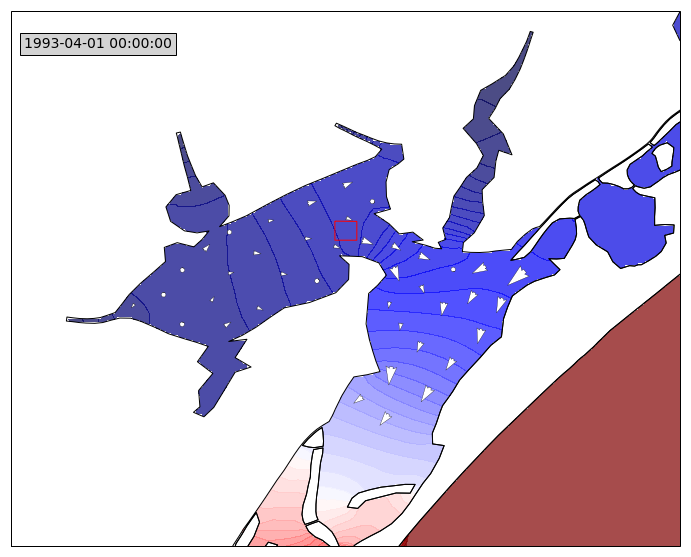

In [12]:
ax = init_plot(extent, geoms)
index = lon.index[0]
time_text = ax.text(0.02, 0.93, index, bbox=dict(facecolor='lightgray', alpha=1), 
                    fontsize=14, weight='medium', transform=ax.transAxes)
sctr = ax.scatter(lon.iloc[0], lat.iloc[0])
u = [outflw1[k]['u'][0] for k in outflw1]
v = [outflw1[k]['v'][0] for k in outflw1]
quiv = ax.quiver(cknodes['lon'], cknodes['lat'], u, v, scale=8, facecolor='white',
                 edgecolors='black', linewidth=0.3)

loni = np.linspace(coords_clipped['lon'].min(), coords_clipped['lon'].max(), grid_resolution)
lati = np.linspace(coords_clipped['lat'].min(), coords_clipped['lat'].max(), grid_resolution)

sal = np.array(avesal[coords_clipped.index].iloc[0])
sali = griddata(coords_clipped['lon'], coords_clipped['lat'], sal, loni, lati, interp='linear')
sali.mask = ~mask
levels = np.arange(0, 30.5, 0.5)
ticks = np.arange(0, 30.5, 2)
contf = ax.contourf(loni, lati, sali, zorder=0, cmap=plt.cm.seismic, vmin=0, vmax=30, 
                    levels=levels, extend='max', alpha=0.7)

In [9]:
#this is for 100x100
%timeit griddata(coords_clipped['lon'], coords_clipped['lat'], sal, loni, lati, interp='linear')

10 loops, best of 3: 22.3 ms per loop


In [24]:
#this is for 250x250
%timeit griddata(coords_clipped['lon'], coords_clipped['lat'], sal, loni, lati, interp='linear')

10 loops, best of 3: 37.9 ms per loop


In [12]:
%timeit griddata(coords_clipped['lon'], coords_clipped['lat'], sal, loni, lati, interp='linear')

10 loops, best of 3: 86.2 ms per loop


## Improving the salinity contours
It would probably look much better to increase the resolution of the gridded salinity data. Gridding data is pretty fast (22 ms for a 100x100 grid) and the mask is saved which takes the longest amount of time.
* should I create multiple masks and let the user pick the resolution?
* should I just try a single high resolution mask (500x500)?
  * how long would that take in each frame?

In [8]:
mask = create_mask(coords_clipped, grid_resolution, polygon)

In [9]:
mask_list = mask.tolist()
outfile = 'mask.json'
json.dump(mask_list, codecs.open(outfile, 'w', encoding='utf-8'), separators=(',', ':'),
                                 sort_keys=True, indent=4)

In [11]:
mask.shape


(500, 500)